In [285]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import mannwhitneyu
from datetime import datetime, timedelta
import matplotlib.pyplot as plt





In [286]:
def analyze_stock_garch(ticker, pre_start, pre_end, campaign_start, campaign_end, scale_returns=100):
    """
    Analyzes a stock's volatility and returns using GARCH(1,1).
    """
    # Download data
    end_date = (pd.to_datetime(campaign_end) + timedelta(days=1)).strftime("%Y-%m-%d")
    df = yf.download(ticker, start=pre_start, end=end_date, progress=False, auto_adjust=True)
    
    if df.empty:
        raise ValueError(f"No data found for ticker {ticker}")

    # Flatten columns if needed
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if col[0] != '' else col[1] for col in df.columns]

    df.index = pd.to_datetime(df.index)
    
    # Daily log returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df = df.dropna(subset=['log_return'])
    
    # Pre and campaign returns
    pre_returns = df.loc[(df.index >= pre_start) & (df.index <= pre_end), 'log_return']
    campaign_returns = df.loc[(df.index >= campaign_start) & (df.index <= campaign_end), 'log_return']

    # Average log returns
    avg_pre_return = pre_returns.mean()
    avg_campaign_return = campaign_returns.mean()

    # Daily vol proxy (absolute log return)
    df['daily_vol'] = df['log_return'].abs()
    avg_pre_vol = df.loc[(df.index >= pre_start) & (df.index <= pre_end), 'daily_vol'].mean()
    avg_campaign_vol = df.loc[(df.index >= campaign_start) & (df.index <= campaign_end), 'daily_vol'].mean()

    # Mann-Whitney test on returns and vol
    u_return, p_return = mannwhitneyu(pre_returns, campaign_returns, alternative='two-sided')
    u_vol, p_vol = mannwhitneyu(pre_returns.abs(), campaign_returns.abs(), alternative='two-sided')

    # Fit GARCH(1,1) on pre-period returns
    garch_model = arch_model(pre_returns * scale_returns, vol='Garch', p=1, q=1, dist='normal')
    garch_fit = garch_model.fit(disp='off')

    # Forecast for campaign period
    horizon = len(campaign_returns)
    garch_forecast = garch_fit.forecast(horizon=horizon, reindex=False)
    forecasted_vol = np.sqrt(garch_forecast.variance.values[-1, :]) / scale_returns

    # Actual campaign daily vol
    actual_campaign_vol = campaign_returns.abs()

    results = {
        'ticker': ticker,
        'avg_pre_return': avg_pre_return,
        'avg_campaign_return': avg_campaign_return,
        'avg_pre_vol': avg_pre_vol,
        'avg_campaign_vol': avg_campaign_vol,
        'garch_forecast_vol': forecasted_vol,
        'actual_campaign_vol': actual_campaign_vol.values,
        'mannwhitney_return_p': p_return,
        'mannwhitney_vol_p': p_vol,
        'pre_returns': pre_returns,
        'campaign_returns': campaign_returns
    }
    return results

##### The below cells show indication of an advertising campaign's correlation with higher volatility

In [287]:
# Example stock and periods
ticker = 'CELZ'

pre_start = "2024-09-01"
pre_end = "2024-10-03"

campaign_start = "2024-10-04"
campaign_end = "2024-10-18"

# Run analysis
res = analyze_stock_garch(ticker, pre_start, pre_end, campaign_start, campaign_end, )


Ticker: CELZ
Average Pre-campaign Log Return: -0.0116
Average Campaign-Period Log Return: 0.0378
Mann–Whitney p-value (log returns): 0.0823


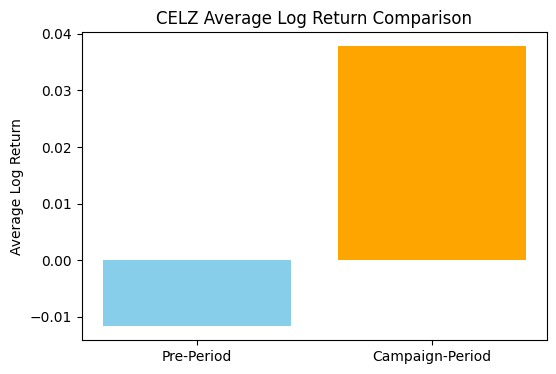

In [288]:
print(f"Ticker: {res['ticker']}")
print(f"Average Pre-campaign Log Return: {res['avg_pre_return']:.4f}")
print(f"Average Campaign-Period Log Return: {res['avg_campaign_return']:.4f}")
print(f"Mann–Whitney p-value (log returns): {res['mannwhitney_return_p']:.4f}")

plt.figure(figsize=(6,4))
plt.bar(['Pre-Period', 'Campaign-Period'], [res['avg_pre_return'], res['avg_campaign_return']], color=['skyblue', 'orange'])
plt.ylabel('Average Log Return')
plt.title(f"{res['ticker']} Average Log Return Comparison")
plt.show()


Average Pre-campaign Daily Volatility: 0.0412
Average Campaign-Period Daily Volatility: 0.0874
Mann–Whitney p-value (volatility): 0.0153


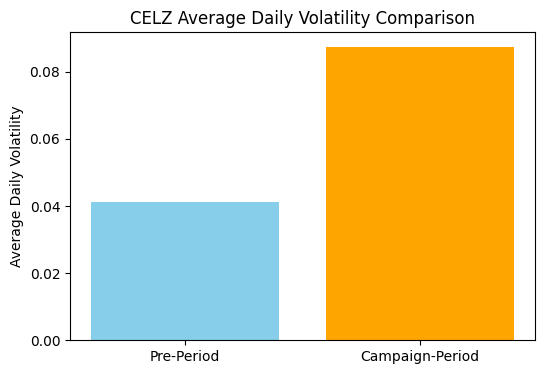

In [289]:
print(f"Average Pre-campaign Daily Volatility: {res['avg_pre_vol']:.4f}")
print(f"Average Campaign-Period Daily Volatility: {res['avg_campaign_vol']:.4f}")
print(f"Mann–Whitney p-value (volatility): {res['mannwhitney_vol_p']:.4f}")

plt.figure(figsize=(6,4))
plt.bar(['Pre-Period', 'Campaign-Period'], [res['avg_pre_vol'], res['avg_campaign_vol']], color=['skyblue', 'orange'])
plt.ylabel('Average Daily Volatility')
plt.title(f"{res['ticker']} Average Daily Volatility Comparison")
plt.show()




In [290]:

print(f"Average GARCH Forecasted Volatility: {np.mean(res['garch_forecast_vol']):.4f}")
print(f"Average Actual Campaign Volatility: {np.mean(res['actual_campaign_vol']):.4f}")





Average GARCH Forecasted Volatility: 0.0210
Average Actual Campaign Volatility: 0.0874


In [291]:
from scipy.stats import ks_2samp

ks_stat, ks_p = ks_2samp(res['pre_returns'], res['campaign_returns'])
print(f"KS Statistic (returns): {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS Statistic (returns): 0.4545, p-value: 0.0866


In [ ]:
def fetch_aligned_returns(ticker, campaign_start, pre_len=30, camp_len=5):

    campaign_start = pd.to_datetime(campaign_start)

    # Fetch more than needed
    start_fetch = campaign_start - pd.Timedelta(days=60)
    end_fetch = campaign_start + pd.Timedelta(days=30)

    data = yf.download(ticker, start=start_fetch, end=end_fetch, progress=False, auto_adjust=True)

    # Flatten columns if it's a MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [col[0] if col[0] != '' else col[1] for col in data.columns]

    if 'Adj Close' in data.columns:
        price = data["Adj Close"]
    elif "Close" in data.columns:
        price = data["Close"]
    else:
        raise ValueError("No price column found in downloaded data")

    log_ret = np.log(price / price.shift(1)).dropna()

    # Find index of campaign start
    pos = log_ret.index.get_indexer([campaign_start], method="bfill")[0]
    if pos == -1:
        raise ValueError(f"Campaign date {campaign_start} not in trading calendar for {ticker}")
    camp_start_idx = pos

    # Slice pre and campaign periods
    pre = log_ret.iloc[camp_start_idx - pre_len : camp_start_idx]
    camp = log_ret.iloc[camp_start_idx : camp_start_idx + camp_len]

    # Build DataFrame with relative indices
    df_pre = pd.DataFrame({
        "day_idx": range(-pre_len, 0),
        "log_return": pre.values
    })
    df_camp = pd.DataFrame({
        "day_idx": range(0, camp_len),
        "log_return": camp.values
    })

    return pd.concat([df_pre, df_camp], ignore_index=True)


##### We extend the analysis by observing every RedChip advertising campaign from 2024 - Aug 2025

In [299]:
ticker_configs = [
    ("APVO", "2024-11-18"),
    ("APVO", "2024-12-04"),
    ("APVO", "2025-02-17"),
    ("BFRG", "2024-02-05"),
    ("BFRG", "2024-07-23"),
    ("BFRG", "2025-04-10"),
    ("BIAF", "2024-02-21"),
    ("BIAF", "2024-04-01"),
    ("BIAF", "2024-05-16"),
    ("BIAF", "2024-06-27"),
    ("BIAF", "2024-07-22"),
    ("BIAF", "2024-09-12"),
    ("BIAF", "2024-12-11"),
    ("BIVI", "2024-06-17"),
    ("BIVI", "2024-10-21"),
    ("BIVI", "2025-05-01"),
    ("CELZ", "2024-10-08"),
    ("CELZ", "2024-01-27"),
    ("CLDI", "2024-04-03"),
    ("CLDI", "2024-05-28"),
    ("CLDI", "2024-07-07"),
    ("CLDI", "2024-08-05"),
    ("CLDI", "2024-10-16"),
    ("CLDI", "2025-03-04"),
    ("CLDI", "2025-07-01"),
    ("ENLV", "2024-09-11"),
    ("ENLV", "2024-10-14"),
    ("ENLV", "2024-12-04"),
    ("ENLV", "2025-02-26"),
    ("ENLV", "2025-08-19"),
    ("FBLG", "2024-08-26"),
    ("FBLG", "2024-10-30"),
    ("FBLG", "2025-01-30"),
    ("FBLG", "2025-04-14"),
    ("FMST", "2025-05-12"),
    ("GP", "2024-09-09"),
    ("GP", "2024-11-26"),
    ("LTRN", "2024-02-26"),
    ("MLSS", "2024-11-19"),
    ("MMA", "2024-05-13"),
    ("MMA", "2024-10-22"),
    ("NXL", "2024-04-01"),
    ("NXL", "2024-06-17"),
    ("NXL", "2024-10-16"),
    ("NXL", "2025-02-03"),
    ("SXTP", "2024-05-20"),
    ("SXTP", "2025-07-28"),
    ("TRIB", "2024-06-03"),
    ("TRIB", "2024-07-09"),
    ("TRIB", "2024-10-01"),
    ("TRIB", "2024-11-06"),
    ("TRIB", "2025-04-16"),
    ("TRIB", "2025-08-01"),
    ("VMAR", "2024-10-31"),
    ("VMAR", "2024-12-06"),
    ("VMAR", "2025-06-25"),
]

aligned_returns = {}

for ticker, camp_start in ticker_configs:
    # Use ticker + date as dict key to make it unique
    key = f"{ticker}_{camp_start}"
    aligned_returns[key] = fetch_aligned_returns(ticker, camp_start)

# Normalize
normalized = {}
for key, df in aligned_returns.items():
    pre = df[df['day_idx'] < 0]['log_return']
    camp = df[df['day_idx'] >= 0]['log_return']
    mu, sigma = pre.mean(), pre.std()
    pre_z = (pre - mu) / sigma
    camp_z = (camp - mu) / sigma
    df['log_return_z'] = pd.concat([pre_z, camp_z]).values
    normalized[key] = df



##### The graph below shows some wider dispersion during the post-campaign period

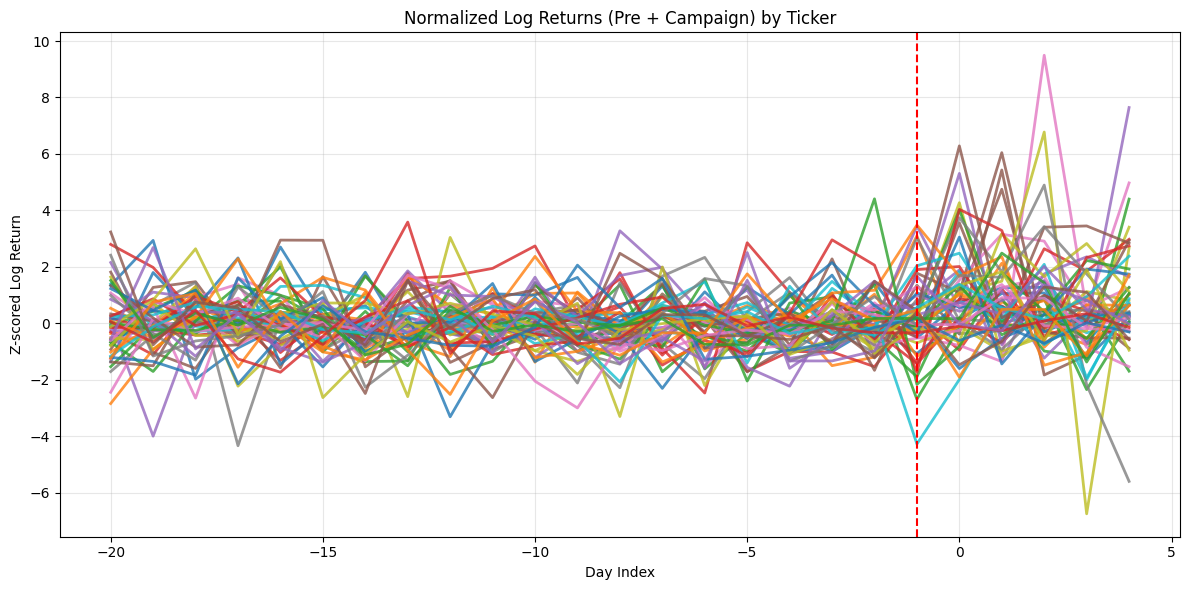

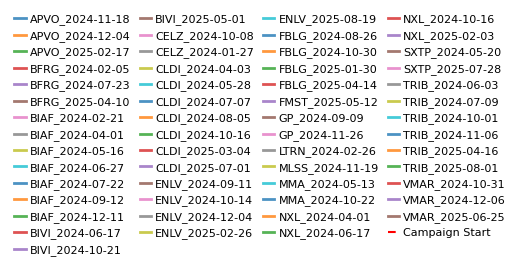

In [313]:
def plot_normalized_returns(normalized_dict, campaigns=None, pre_days=None,
                            figsize=(12,6), lw=2, alpha=0.8,
                            show_red_line=True, title=None,
                            legend_in_new_fig=True):

    fig, ax = plt.subplots(figsize=figsize)
    
    if campaigns is None:
        campaigns = normalized_dict.keys()
    
    for key in campaigns:
        df = normalized_dict[key].copy()
        
        # Slice pre-period if requested
        if pre_days is not None:
            df = df[(df['day_idx'] >= -pre_days) | (df['day_idx'] >= 0)]
        
        ax.plot(df['day_idx'], df['log_return_z'], label=key, lw=lw, alpha=alpha)
    
    if show_red_line:
        ax.axvline(-1, color='red', linestyle='--', label='Campaign Start')
    
    ax.set_xlabel('Day Index')
    ax.set_ylabel('Z-scored Log Return')
    ax.set_title(title or 'Normalized Log Returns (Pre + Campaign) by Ticker')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Legend in separate figure
    if legend_in_new_fig:
        handles, labels = ax.get_legend_handles_labels()
        fig_leg = plt.figure(figsize=(2, 1))
        fig_leg.legend(handles, labels,
                    loc='center',
                    ncol=4,              
                    frameon=False,
                    fontsize=8,          
                    handlelength=1,      
                    handletextpad=0.4,   
                    columnspacing=0.8)   
        plt.axis('off')
        plt.show()


plot_normalized_returns(normalized, pre_days=20)


In [314]:

from scipy.stats import skew

def compute_campaign_stats(normalized_dict, campaigns=None, a=30, b=30):

    if campaigns is None:
        campaigns = normalized_dict.keys()
    
    # Store individual campaign stats
    stats = {}
    
    for key in campaigns:
        df = normalized_dict[key].copy()
        
        # Pre/post slices
        pre = df[(df["day_idx"] < 0) & (df["day_idx"] >= -a)]["log_return_z"]
        post = df[(df["day_idx"] >= 0) & (df["day_idx"] <= b)]["log_return_z"]
        
        if pre.empty or post.empty:
            stats[key] = {"pre_mean": np.nan,
                          "pre_abs_mean": np.nan,
                          "post_abs_mean": np.nan,
                          "post_mean": np.nan,
                          "post_skew": np.nan}
            continue
        
        stats[key] = {
            "pre_mean": pre.mean(),
            "pre_abs_mean": np.mean(np.abs(pre)),
            "post_abs_mean": np.mean(np.abs(post)),
            "post_mean": post.mean(),
            "post_skew": skew(post)
        }
    
    # Convert to DataFrame
    campaign_stats = pd.DataFrame.from_dict(stats, orient="index")
    
    # Overall summary
    overall_summary = pd.DataFrame({
        "mean": campaign_stats.mean(),
        "std": campaign_stats.std(),
        "min": campaign_stats.min(),
        "max": campaign_stats.max()
    })
    
    # Aggregate by stock
    campaign_stats["stock"] = [key.split("_")[0] for key in campaign_stats.index]
    stock_summary = campaign_stats.groupby("stock").mean()
    
    return campaign_stats, overall_summary, stock_summary

campaign_stats, overall_summary, stock_summary = compute_campaign_stats(normalized, a=10, b=5)


print("\n=== Overall summary across all campaigns ===")
display(overall_summary)

print("\n=== Stock-level aggregated stats ===")
display(stock_summary)




=== Overall summary across all campaigns ===


,mean,std,min,max
pre_mean,-0.011716,0.274039,-0.705939,0.607624
pre_abs_mean,0.733822,0.267296,0.225831,1.279846
post_abs_mean,1.250476,0.839789,0.189130,3.755560
post_mean,0.692239,0.756478,-0.344105,2.608832
post_skew,0.019149,0.765044,-1.392246,1.374608



=== Stock-level aggregated stats ===


,pre_mean,pre_abs_mean,post_abs_mean,post_mean,post_skew
stock,,,,,
APVO,-0.189742,0.748599,0.672860,0.206360,-0.380059
BFRG,0.101022,1.052001,1.214015,0.311427,0.441910
BIAF,-0.084506,0.600121,1.256326,0.782895,0.509416
BIVI,0.171984,0.710591,0.902604,0.430018,-0.074159
CELZ,-0.071850,0.806006,1.066971,0.934350,0.156875
CLDI,-0.133168,0.569792,1.057578,0.482815,0.188645
ENLV,-0.021809,0.828813,1.553142,0.376993,-0.144373
FBLG,0.043645,0.783073,0.975350,0.773925,-0.728262
FMST,0.529316,1.279846,2.365277,2.058143,0.318803


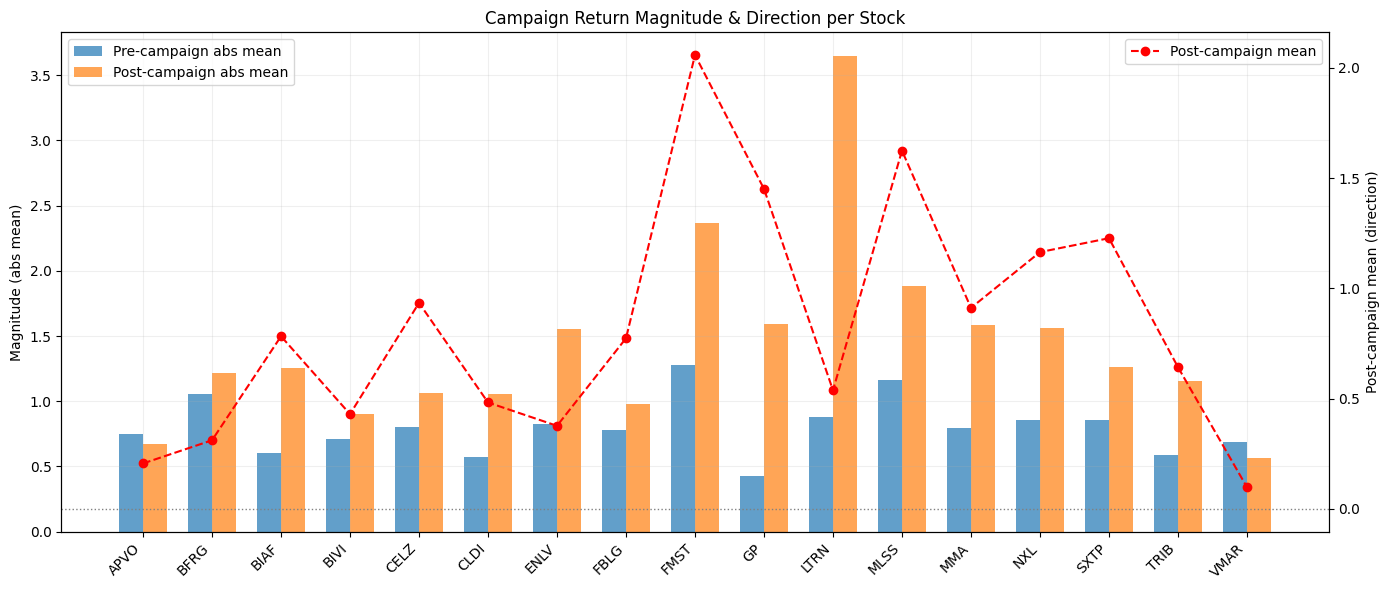

In [315]:


def plot_stock_campaign_summary(stock_summary, figsize=(14,6)):

    stocks = stock_summary.index
    x = np.arange(len(stocks))
    width = 0.35

    fig, ax = plt.subplots(figsize=figsize)

    # Magnitude bars
    ax.bar(x - width/2, stock_summary["pre_abs_mean"], width, label="Pre-campaign abs mean", alpha=0.7)
    ax.bar(x + width/2, stock_summary["post_abs_mean"], width, label="Post-campaign abs mean", alpha=0.7)

    # Overlay post_mean as a line
    ax2 = ax.twinx()
    ax2.plot(x, stock_summary["post_mean"], color="red", marker="o", linestyle="--", label="Post-campaign mean")
    ax2.set_ylabel("Post-campaign mean (direction)")

    # Labels
    ax.set_xticks(x)
    ax.set_xticklabels(stocks, rotation=45, ha="right")
    ax.set_ylabel("Magnitude (abs mean)")
    ax.set_title("Campaign Return Magnitude & Direction per Stock")
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    
plot_stock_campaign_summary(stock_summary)


###### The bar chart above demonstrates the difference in absolute log returns aggregated for each stocks' campaign(s). The positive red line indicates that for every campaign the stock always rose in the days after a campaign. Such a trend may be attributed to news releases coinciding with the advertising campaigns, but not necessarily. Nevertheless the advertising campaigns are a signal for increased volatility and upwards price movement.

In [316]:
from scipy.stats import skew
import numpy as np
import pandas as pd

def compute_campaign_stats_shifted(normalized_dict, campaigns=None, a=30, b=30):
    """
    Compute statistics for pre-campaign and post-campaign (starting day after campaign start)
    """
    if campaigns is None:
        campaigns = normalized_dict.keys()
    
    stats = {}
    
    for key in campaigns:
        df = normalized_dict[key].copy()
        
        # Pre-campaign: same as before
        pre = df[(df["day_idx"] < 0) & (df["day_idx"] >= -a)]["log_return_z"]
        
        # Post-campaign: start from day_idx=1 (day after campaign start)
        post = df[(df["day_idx"] > 1) & (df["day_idx"] <= b)]["log_return_z"]
        
        if pre.empty or post.empty:
            stats[key] = {"pre_mean": np.nan,
                          "pre_abs_mean": np.nan,
                          "post_abs_mean": np.nan,
                          "post_mean": np.nan,
                          "post_skew": np.nan}
            continue
        
        stats[key] = {
            "pre_mean": pre.mean(),
            "pre_abs_mean": np.mean(np.abs(pre)),
            "post_abs_mean": np.mean(np.abs(post)),
            "post_mean": post.mean(),
            "post_skew": skew(post)
        }
    
    # Convert to DataFrame
    campaign_stats = pd.DataFrame.from_dict(stats, orient="index")
    
    # Overall summary
    overall_summary = pd.DataFrame({
        "mean": campaign_stats.mean(),
        "std": campaign_stats.std(),
        "min": campaign_stats.min(),
        "max": campaign_stats.max()
    })
    
    # Aggregate by stock
    campaign_stats["stock"] = [key.split("_")[0] for key in campaign_stats.index]
    stock_summary = campaign_stats.groupby("stock").mean()
    
    return campaign_stats, overall_summary, stock_summary

# Example usage
campaign_stats_shifted, overall_summary_shifted, stock_summary_shifted = compute_campaign_stats_shifted(normalized, a=10, b=5)

print("\n=== Overall summary across all campaigns (post starts day after first campaign day) ===")
display(overall_summary_shifted)

print("\n=== Stock-level aggregated stats (post starts day after first campaign day) ===")
display(stock_summary_shifted)



=== Overall summary across all campaigns (post starts day after first campaign day) ===


,mean,std,min,max
pre_mean,-0.011716,0.274039,-0.705939,0.607624
pre_abs_mean,0.733822,0.267296,0.225831,1.279846
post_abs_mean,1.222435,1.118446,0.170366,5.399434
post_mean,0.585741,1.066380,-0.959007,4.978579
post_skew,-0.004259,0.532805,-0.707106,0.703263



=== Stock-level aggregated stats (post starts day after first campaign day) ===


,pre_mean,pre_abs_mean,post_abs_mean,post_mean,post_skew
stock,,,,,
APVO,-0.189742,0.748599,0.726279,-0.032474,-0.370048
BFRG,0.101022,1.052001,0.783532,-0.136832,0.320437
BIAF,-0.084506,0.600121,1.408659,1.023483,0.198303
BIVI,0.171984,0.710591,0.599965,-0.030916,0.190119
CELZ,-0.071850,0.806006,0.891652,0.881845,0.244463
CLDI,-0.133168,0.569792,1.139626,0.496320,-0.057934
ENLV,-0.021809,0.828813,1.606546,0.068250,-0.110784
FBLG,0.043645,0.783073,1.071599,0.841605,-0.436171
FMST,0.529316,1.279846,1.916401,1.916401,0.648462


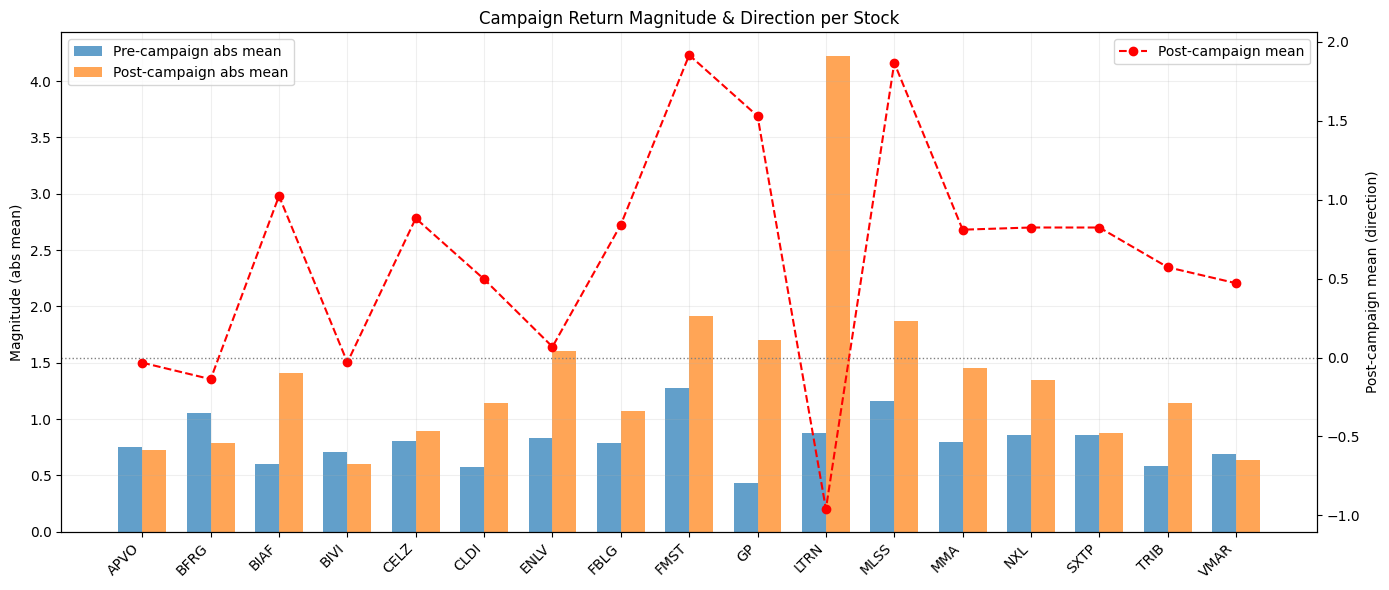

In [317]:
# Plot for shifted post-campaign (day after first campaign day)
plot_stock_campaign_summary(stock_summary_shifted)



###### Here I've included the same data as above but shifted forward by one day. This models the stocks' behavior the day AFTER the campaign begins, as though you had no prior knowledge that a campaign was beginning. The idea being that if you saw a commercial on the first day of the campaign and THEN opened a position. Understandably, there are more negative post-campaign mean values than in the original comparing strictly pre vs post. This pre vs post +1 day shows lower increases in absolute mean price movements as well. It pays to be informed!